In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import zipfile
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import os


# Path to the uploaded zip file in Drive
zip_path = '/content/drive/MyDrive/Autism.zip'
extract_path = '/content/Autism_extract'

# Step 2: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted successfully.")

# Define paths to autistic and non-autistic image folders
autistic_path = os.path.join(extract_path, 'train', 'autistic')
non_autistic_path = os.path.join(extract_path, 'train', 'non_autistic')

# Step 3: Initialize data containers
images = []
labels = []


Dataset extracted successfully.


In [3]:
# Preprocessing Function
def preprocess_image(img_path, img_size=(224, 224)):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Cannot load image: {img_path}")
            return None
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to [0, 1]
        return img
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Step 4: Load images and labels
for folder_path, label in [(autistic_path, 1), (non_autistic_path, 0)]:
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            processed_image = preprocess_image(file_path)
            if processed_image is not None:
                images.append(processed_image)
                labels.append(label)
        else:
            print(f"Skipping non-image file: {filename}")

print(f"Loaded {len(images)} images and {len(labels)} labels.")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")


Loaded 2536 images and 2536 labels.
Images shape: (2536, 224, 224, 3), Labels shape: (2536,)


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Summary of the dataset
images.shape, labels.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2536, 224, 224, 3),
 (2536,),
 (2028, 224, 224, 3),
 (508, 224, 224, 3),
 (2028,),
 (508,))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255,  # Normalize image pixel values to [0,1]
                             rotation_range=30,  # Random rotations
                             width_shift_range=0.2,  # Random horizontal shifts
                             height_shift_range=0.2,  # Random vertical shifts
                             shear_range=0.2,  # Random shear transformations
                             zoom_range=0.2,  # Random zoom
                             horizontal_flip=True,  # Random horizontal flip
                             fill_mode='nearest')  # How to fill missing pixels after transformations

# Use the data generator to flow data from the images
train_gen = datagen.flow(X_train, y_train, batch_size=32)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout

# Define the model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Global average pooling layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification (autistic vs non-autistic)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

# Train the model
history = model.fit(train_gen, epochs=10, validation_data=(X_test, y_test))



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6502 - loss: 0.6916 - val_accuracy: 0.5138 - val_loss: 6.6395
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 397ms/step - accuracy: 0.7290 - loss: 0.5487 - val_accuracy: 0.5138 - val_loss: 6.1930
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 409ms/step - accuracy: 0.7832 - loss: 0.4737 - val_accuracy: 0.5138 - val_loss: 5.8698
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.7801 - loss: 0.4297 - val_accuracy: 0.5217 - val_loss: 4.9919
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 376ms/step - accuracy: 0.8206 - loss: 0.4216 - val_accuracy: 0.5256 - val_loss: 4.9593
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - accuracy: 0.8153 - loss: 0.3993 - val_accuracy: 0.5276 - val_loss: 3.9223
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 370ms/step - accuracy: 0.8165 - loss: 0.3865 - val_accuracy: 0.5217 - val_loss: 4.7615
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.8200 - loss: 0.3975 - val_accuracy: 0.5138 

In [8]:
# Assuming y_test is a 1D array (labels are not one-hot encoded)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels

# Now y_test is already in a 1D format, no need to apply np.argmax on it
y_true = y_test

# Classification Report and Confusion Matrix
print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       261
           1       0.00      0.00      0.00       247

    accuracy                           0.51       508
   macro avg       0.26      0.50      0.34       508
weighted avg       0.26      0.51      0.35       508

[[261   0]
 [247   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

# Load the image you want to test
img_path = '/content/Autism_extract/test/autistic/004.jpg'  # Update this with your image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize to the input size of the model

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Normalize the image (same normalization as in training)
img_array = img_array / 255.0

# Add batch dimension (as the model expects input of shape (batch_size, 224, 224, 3))
img_array = np.expand_dims(img_array, axis=0)

# Check the shape of the image array
print(img_array.shape)  # Should be (1, 224, 224, 3)


(1, 224, 224, 3)


In [10]:
# Make a prediction using the trained model
prediction = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(prediction, axis=1)  # 0 for non-autistic, 1 for autistic (assuming binary classification)

# Print the result
if predicted_class == 0:
    print("The child is predicted to be non-autistic.")
else:
    print("The child is predicted to be autistic.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The child is predicted to be non-autistic.


In [19]:
def predict_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    prediction = model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(prediction, axis=1)

    # Return the result
    if predicted_class == 0:
        return "Non-autistic"
    else:
        return "Autistic"

# Example of testing on an image
image_path = '/content/autistic.jpg'  # Update with the path to the image you want to test
result = predict_image(image_path)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Non-autistic


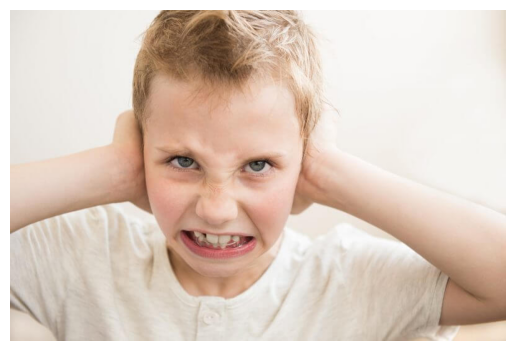

In [20]:
import matplotlib.pyplot as plt

# Display the image
img = cv2.imread(image_path)  # Read image using OpenCV
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for correct display in matplotlib

plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()
